# SI 608 

### Build graph

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from fuzzywuzzy import process

/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
df = pd.read_csv("dblp_graph_conference_v12_new_author.csv")

In [8]:
df.isnull().sum()

index                    0
author_id                0
author_name              0
author_org           88826
id                       0
title                    0
year                     0
n_citation               0
doc_type                 0
reference_count          0
references          105536
venue_id                 0
venue_name               0
venue_type               0
doi                 157790
keyword                  0
volume              947805
issue              1037011
publisher                0
dtype: int64

In [ ]:
df["author_org"] = df["author_org"].fillna("unknown")



Missing doi's do not affect the data and are not filled

Volume and issue are also not filled since there are too many vacancies

#### Title df to Author df

In [12]:
author_df=df

#### Clean org

In [15]:
author_df.isnull().sum()

index                    0
author_id                0
author_name              0
author_org               0
id                       0
title                    0
year                     0
n_citation               0
doc_type                 0
reference_count          0
references          105536
venue_id                 0
venue_name               0
venue_type               0
doi                 157790
keyword                  0
volume              947805
issue              1037011
publisher                0
dtype: int64

In [16]:
def clean_org(org):
    if "email" in org:
        org = org.rsplit(",", 1)[0]
    return org


author_df.loc[author_df["author_org"] == "nan", "author_org"] = "unknown"
author_df["author_org"] = author_df["author_org"].apply(
    lambda x: x.strip('"').replace("#TAB#", "").strip()
)

author_df["author_org"] = author_df["author_org"].apply(clean_org)

In [17]:
print(author_df["author_org"].value_counts())

author_org
unknown                                                                   153105
Carnegie - Mellon University                                                3996
Stanford, University                                                        2273
Carnegie-Mellon Univ., Pittsburgh, PA, USA                                  1954
Carnegie Mellon University, Pittsburgh Pa                                   1756
                                                                           ...  
IRIT-UPS, Toulouse Cedex, France                                               1
THALES Communications France, Colombes, France                                 1
LIRIS, Lyon 1 Univ., Lyon, France                                              1
INRP, ENS Cachan, Cachan, France                                               1
Archaeological Computing Research Group, University of Southampton, UK         1
Name: count, Length: 243247, dtype: int64


In [18]:
author_df["author_org"].isnull().sum()

np.int64(0)

#### Other paper related attributes

In [24]:
author=author_df
author.rename(columns={"author_org":"standard_org"}, inplace=True)

In [25]:
author["publisher"].value_counts()

publisher
IEEE                                                                                               376014
ACM                                                                                                164336
Springer, Berlin, Heidelberg                                                                       157110
unknown                                                                                            108753
Springer, Cham                                                                                      63753
                                                                                                    ...  
IEEE EMBS Int Conf Biomed Health Inform                                                                 1
The 26th International Conference on Software Engineering and Knowledge Engineering (SEKE 2014)         1
The 29th Pacific Asia Conference on Language, Information and Computation                               1
ACADEMIC PRESS LTD- ELSEVIER SCIENCE

In [27]:
author['venue_name'].value_counts()

venue_name
National Conference on Artificial Intelligence                                     15827
Computer Vision and Pattern Recognition                                            15516
International Conference on Acoustics, Speech, and Signal Processing               13433
International Conference on Robotics and Automation                                12741
International Conference on Image Processing                                       11525
                                                                                   ...  
International Symposium on Power Electronics for Distributed Generation Systems        1
IEEE International Conference on Circuits and Systems for Communications               1
European Conference on Radiation and Its Effects on Components and Systems             1
Self-Sustaining Systems                                                                1
International Conference on Software Technology and Engineering                        1
Name: coun

In [28]:
citation_grouped= author.groupby("author_id")['n_citation'].sum().reset_index(name="total_citation")
author=author.merge(citation_grouped, on="author_id", how="left")

paper_grouped= author.groupby("author_id")['index'].count().reset_index(name="total_paper")
author=author.merge(paper_grouped, on="author_id", how="left")

reference_grouped= author.groupby("author_id")['reference_count'].mean().reset_index(name="avg_reference")
author=author.merge(reference_grouped, on="author_id", how="left")



In [29]:
def merge_keywords(keywords):
    all_keywords = set()
    for kw in keywords:
        all_keywords.update(kw.split(';'))
    return all_keywords


author_keywords = author.groupby("author_id")["keyword"].apply(merge_keywords).reset_index(name='total_keyword')
author=author.merge(author_keywords, on="author_id", how="left")

### Split train and validation

In [114]:
most_recent_indices = author.groupby("author_id")["year"].idxmax()

valid = author.loc[most_recent_indices]

train = author.drop(most_recent_indices)

In [116]:
valid_author_ids = valid['author_id'].unique()
train_author_ids = train['author_id'].unique()

# Find authors present in train but not in valid
missing_from_valid = [author_id for author_id in train_author_ids if author_id not in valid_author_ids]
print("Authors in train but not in valid:", missing_from_valid)


Authors in train but not in valid: []


In [118]:
print(valid.loc[valid["author_id"] == 2009849051])

         index   author_id        author_name               standard_org  \
473459  321708  2009849051  Michael O. Jewell  University Of Southampton   

                id                                              title  year  \
473459  2096264819  Understanding Energy Consumption at Work: Lear...  2016   

        n_citation    doc_type  reference_count  ... venue_type  \
473459           8  Conference             29.0  ...          C   

                                            doi  \
473459  https://doi.org/10.1145/2818048.2819993   

                                                  keyword volume issue  \
473459  Energy conservation;Psychological intervention...    NaN   NaN   

       publisher  total_citation  total_paper avg_reference  \
473459       ACM              93           13     16.230769   

                                            total_keyword  
473459  {Computer science, Correctness, Arrow, Themati...  

[1 rows x 23 columns]


#### Build the graph

In [ ]:
# G_train = nx.Graph()

In [ ]:

# for index, row in train.iterrows():
#     author_id = row['author_id']
#     if not G_train.has_node(author_id):
#         G_train.add_node(
#             author_id,
#             name=row['author_name'],
#             org=row['standard_org'],
#             total_citation=row["total_citation"], 
#             total_paper=row["total_paper"],
#             avg_reference=row["avg_reference"],     
#             keywords=row["total_keyword"],   
#         )


In [ ]:

# for paper_id, group in train.groupby('id'):
#     authors = group['author_id'].tolist()
#     id = group['id'].iloc[0]
#     title = group['title'].iloc[0]
#     year = group['year'].iloc[0]
#     venue_id = group['venue_id'].iloc[0]
#     venue_name = group['venue_name'].iloc[0]
#     publisher = group['publisher'].iloc[0]
#     n_citation = group['n_citation'].iloc[0]  # 本篇文章的引用数

#     for i in range(len(authors)):
#         for j in range(i + 1, len(authors)):
#             author1 = authors[i]
#             author2 = authors[j]

#             if G_train.has_edge(author1, author2):
#                 G_train[author1][author2]['papers'].append({
#                     'id': id,
#                     'title': title,
#                     'year': year,
#                     'venue_id': venue_id,
#                     'venue_name': venue_name,
#                     'publisher': publisher,
#                     'n_citation': n_citation,  # 添加引用数
#                 })
#             else:
#                 G_train.add_edge(author1, author2, papers=[{
#                     'id': id,
#                     'title': title,
#                     'year': year,
#                     'venue_id': venue_id,
#                     'venue_name': venue_name,
#                     'publisher': publisher,
#                     'n_citation': n_citation,  # 添加引用数
#                 }])


### Network Analysis

In [35]:
print("# components: ",nx.number_connected_components(G_train))

nodes_num=len(G_train.nodes())
print('# nodes: ',nodes_num)

edges_num=len(G_train.edges())
print('# edge: ',edges_num)

largest_component = max(nx.connected_components(G_train), key=len)
percent_lc=round(len(largest_component)/nodes_num*100,2)
print("%_largest component: ",percent_lc)

# average degree
degree_dict=dict(nx.degree(G_train))
avg_d=sum(degree_dict.values())/len(G_train.nodes())
print("average degree: ",avg_d)

# average clustering coefficient
avg_cc=nx.average_clustering(G_train)
print("average clustering coefficient: ",avg_cc)

# components:  1095
# nodes:  29694
# edge:  153857
%_largest component:  94.4
average degree:  10.362834242607935
average clustering coefficient:  0.37782319359036604


### GNN 0

In [90]:
# 优化
import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class TemporalAuthorGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TemporalAuthorGNN, self).__init__()
        # 时序图卷积层
        self.conv1 = pyg_nn.TAGConv(num_features, hidden_channels)
        self.conv2 = pyg_nn.TAGConv(hidden_channels, 1)  # 输出层预测citation数量
        
    def forward(self, x, edge_index, edge_attr):
        # 第一层图卷积，使用edge_attr传递时间信息
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        
        # 第二层图卷积，输出预测的引用数量
        x = self.conv2(x, edge_index, edge_attr)
        return x

def prepare_temporal_graph_data(train, valid):
    # 前面的准备图数据的代码保持不变
    # ...（使用之前的实现）
    def calculate_h_index(citations):
     sorted_citations = sorted(citations, reverse=True)
     h_index = 0
     for i, cite_count in enumerate(sorted_citations, 1):
        if cite_count >= i:
            h_index = i
        else:
            break
     return h_index
    def extract_author_features(group):
        sorted_years = group.sort_values('year')
        citations = sorted_years['n_citation'].values
    
        # 引用增量：后一年减去前一年的引用数
        citation_increments = [citations[i] - citations[i - 1] for i in range(1, len(citations))]
    
        return {
            'total_citation': group['n_citation'].sum(),
            'paper_count': len(group),
            'avg_citation': group['n_citation'].mean(),
            'min_year': group['year'].min(),
            'max_year': group['year'].max(),
            'h_index': calculate_h_index(group['n_citation']),  # 学术影响力指标
            'citation_variance': group['n_citation'].var(),  # 引用数方差
            'recent_citation_ratio': group[group['year'] > group['year'].max() - 3]['n_citation'].sum()/ group['n_citation'].sum(),
            'citation_increment': sum(citation_increments) / len(citation_increments) if citation_increments else 0
        }
    
    # 计算作者历史特征
    author_features = train.groupby('author_id').apply(extract_author_features)
    
    # 准备节点特征
    node_features = []
    node_ids = list(author_features.index)
    
    for node in node_ids:
        features = [
            author_features.loc[node]['total_citation'],
            author_features.loc[node]['paper_count'],
            author_features.loc[node]['avg_citation'],
            author_features.loc[node]['max_year'] - author_features.loc[node]['min_year'] + 1
        ]
        node_features.append(features)
    
    # 转换节点特征
    x = torch.tensor(node_features, dtype=torch.float)
    
    # 构建边和边属性
    edges = []
    edge_attrs = []
    
    # 遍历每篇论文的合作关系
    for paper_id, group in train.groupby('id'):
        authors = group['author_id'].tolist()
        year = group['year'].iloc[0]
        
        # 创建作者间的边
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                author1 = authors[i]
                author2 = authors[j]
                
                # 边的索引
                edge = [node_ids.index(author1), node_ids.index(author2)]
                edges.append(edge)
                edges.append(edge[::-1])  # 添加反向边
                
                # 边属性使用论文发表年份
                edge_attrs.append([year])
                edge_attrs.append([year])
    
    # 转换边和边属性
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    return x, edge_index, edge_attr, node_ids
    


In [91]:
#优化
class TemporalAuthorGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TemporalAuthorGNN, self).__init__()
        # 增加更多层和dropout
        self.conv1 = pyg_nn.TAGConv(num_features, hidden_channels)
        self.conv2 = pyg_nn.TAGConv(hidden_channels, hidden_channels//2)
        self.conv3 = pyg_nn.TAGConv(hidden_channels//2, 1)
        
        # 添加批归一化和dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels//2)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_attr)
        return x

In [92]:
#优化
def train_and_evaluate_temporal_gnn(train, valid):
    # 学习率调度器
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-4
    )

    # 早停
    early_stopping_patience = 20
    no_improvement_epochs = 0

    for epoch in range(100):
        # 训练代码...
        # 如果验证误差没有改善
        if mae >= best_mae:
            no_improvement_epochs += 1
            if no_improvement_epochs > early_stopping_patience:
                print("Early stopping triggered")
                break
        else:
            no_improvement_epochs = 0

        # 更新学习率
        lr_scheduler.step(mae)

In [93]:
# 优化
def cross_validation(train_data):
    # K折交叉验证
    kf = KFold(n_splits=5, shuffle=True)
    
    all_metrics = []
    for train_index, val_index in kf.split(train_data):
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]
        
        model, predictions, metrics = train_and_evaluate_temporal_gnn(train_fold, val_fold)
        all_metrics.append(metrics)

    # 平均指标
    avg_metrics = {
        'mse': np.mean([m['mse'] for m in all_metrics]),
        'mae': np.mean([m['mae'] for m in all_metrics]),
        'r2': np.mean([m['r2'] for m in all_metrics])
    }

/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/152240381.py:53: RuntimeWarning: invalid value encountered in scalar divide
  'recent_citation_ratio': group[group['year'] > group['year'].max() - 3]['n_citation'].sum()/ group['n_citation'].sum(),
/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/152240381.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  author_features = train.groupby('author_id').apply(extract_author_features)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likel

Epoch 0:
MSE Loss: 448.3621
MAE: 4.3284
R2 Score: -0.0400
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 10:
MSE Loss: 439.5737
MAE: 5.3247
R2 Score: -0.0074
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 20:
MSE Loss: 433.2318
MAE: 5.6597
R2 Score: -0.0236
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 30:
MSE Loss: 431.7821
MAE: 5.4391
R2 Score: -0.0074
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 40:
MSE Loss: 431.0801
MAE: 5.7008
R2 Score: -0.0093
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 50:
MSE Loss: 430.7357
MAE: 5.7786
R2 Score: 0.0013
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 60:
MSE Loss: 430.6352
MAE: 5.7850
R2 Score: 0.0005
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 70:
MSE Loss: 430.5115
MAE: 5.6825
R2 Score: 0.0005
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi


最终模型性能:
MSE: 430.1070
MAE: 5.6910
R2 Score: 0.0007


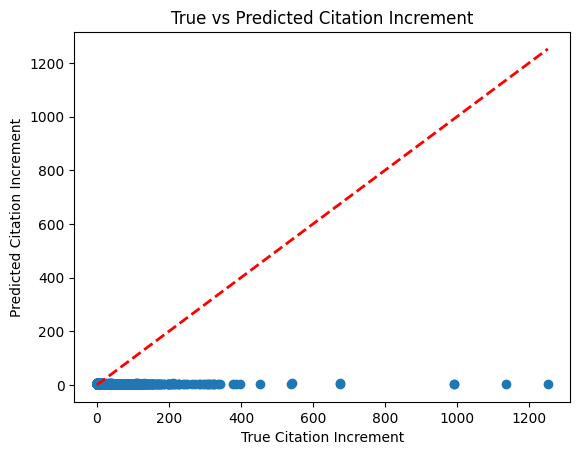

In [97]:

def train_and_evaluate_temporal_gnn(train, valid):
    # 准备图数据
    x, edge_index, edge_attr, node_ids = prepare_temporal_graph_data(train, valid)
    
    # 定义模型超参数
    num_features = x.shape[1]
    hidden_channels = 64
    
    # 初始化模型
    model = TemporalAuthorGNN(num_features, hidden_channels)
    
    # 损失函数和优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mse_criterion = torch.nn.MSELoss()
    
    # 准备验证集目标值
    valid_author_ids = valid['author_id'].unique()
    valid_targets = []
    valid_indices = []
    
    for author_id in valid_author_ids:
        author_index = node_ids.index(author_id)
        valid_target = valid[valid['author_id'] == author_id]['n_citation'].values[0]
        
        valid_targets.append(valid_target)
        valid_indices.append(author_index)
    
    valid_targets = torch.tensor(valid_targets, dtype=torch.float)
    
    # 训练循环
    model.train()
    best_mae = float('inf')
    best_model = None
    
    for epoch in range(80):
        optimizer.zero_grad()
        
        # 前向传播
        predictions = model(x, edge_index, edge_attr)
        
        # 计算损失
        loss = mse_criterion(predictions[valid_indices], valid_targets)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 模型评估
        with torch.no_grad():
            model.eval()
            pred_values = predictions[valid_indices].numpy()
            true_values = valid_targets.numpy()
            
            # 计算评估指标
            mae = mean_absolute_error(true_values, pred_values)
            r2 = r2_score(true_values, pred_values)
            
            # 保存最佳模型
            if mae < best_mae:
                best_mae = mae
                best_model = model.state_dict().copy()
            
            # 每10轮打印一次评估指标
            if epoch % 10 == 0:
                print(f'Epoch {epoch}:')
                print(f'MSE Loss: {loss.item():.4f}')
                print(f'MAE: {mae:.4f}')
                print(f'R2 Score: {r2:.4f}')
                print('-' * 30)
    
    # 恢复最佳模型
    model.load_state_dict(best_model)
    
    # 最终评估
    model.eval()
    with torch.no_grad():
        final_predictions = model(x, edge_index, edge_attr)[valid_indices].numpy()
        final_true_values = valid_targets.numpy()
        
        final_mse = mean_squared_error(final_true_values, final_predictions)
        final_mae = mean_absolute_error(final_true_values, final_predictions)
        final_r2 = r2_score(final_true_values, final_predictions)
        
        print("\n最终模型性能:")
        print(f"MSE: {final_mse:.4f}")
        print(f"MAE: {final_mae:.4f}")
        print(f"R2 Score: {final_r2:.4f}")
    
    # 可视化预测结果
    # plt.figure(figsize=(10, 6))
    # plt.scatter(final_true_values, final_predictions)
    # plt.plot([final_true_values.min(), final_true_values.max()], 
    #          [final_true_values.min(), final_true_values.max()], 
    #          'r--', lw=2)
    # plt.xlabel("True Citations")
    # plt.ylabel("Predicted Citations")
    # plt.title("True vs Predicted Citations")
    plt.scatter(final_true_values, final_predictions)
    plt.plot([final_true_values.min(), final_true_values.max()], 
            [final_true_values.min(), final_true_values.max()], 
            'r--', lw=2)
    plt.xlabel("True Citation Increment")
    plt.ylabel("Predicted Citation Increment")
    plt.title("True vs Predicted Citation Increment")

    plt.show()
    
    return model, final_predictions, {
        'mse': final_mse,
        'mae': final_mae,
        'r2': final_r2
    }

# 使用示例
model, predictions, metrics = train_and_evaluate_temporal_gnn(train, valid)

In [80]:
predictions.shape

(29694, 1)

In [98]:
print(predictions)

[[3.6793044]
 [4.027608 ]
 [4.2797637]
 ...
 [4.0865855]
 [3.7077227]
 [4.4538975]]


In [101]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


20%阈值准确率: 0.0526
10%阈值准确率: 0.0284


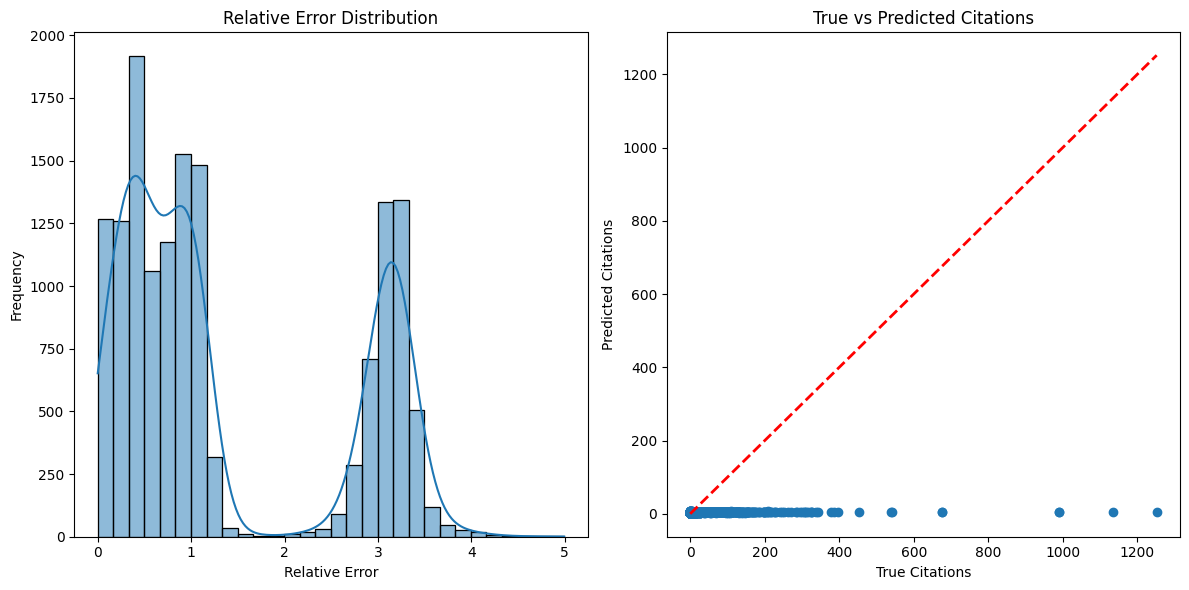

Accuracy_10.0%: 0.0284
Mean_Error_10.0%: 0.0424
Count_10.0%: 844.0000
Accuracy_20.0%: 0.0526
Mean_Error_20.0%: 0.0946
Count_20.0%: 1563.0000
Accuracy_30.0%: 0.0723
Mean_Error_30.0%: 0.1384
Count_30.0%: 2146.0000
Accuracy_50.0%: 0.1497
Mean_Error_50.0%: 0.2718
Count_50.0%: 4446.0000


In [102]:
predictions_1d = predictions.reshape(-1)

# 创建一个包含index和预测值的Series
predicted_citations_series = pd.Series(predictions_1d, index=valid.index)


# 将预测值添加到验证集DataFrame
valid_with_predictions = valid.copy()
valid_with_predictions['predicted_citations'] = predicted_citations_series

# 计算相对误差
valid_with_predictions['relative_error'] = np.abs(
    valid_with_predictions['n_citation'] - valid_with_predictions['predicted_citations']
) / valid_with_predictions['n_citation']

# 计算不同阈值下的准确率
def calculate_accuracy(df, threshold=0.2):
    """
    计算在给定阈值下的准确率
    
    Args:
    - df: 包含真实和预测引用数的DataFrame
    - threshold: 相对误差阈值
    
    Returns:
    - accuracy: 准确率
    """
    accurate_predictions = df[df['relative_error'] <= threshold]
    accuracy = len(accurate_predictions) / len(df)
    return accuracy

# 计算不同阈值的准确率
accuracy_20percent = calculate_accuracy(valid_with_predictions, threshold=0.2)
accuracy_10percent = calculate_accuracy(valid_with_predictions, threshold=0.1)

print(f"20%阈值准确率: {accuracy_20percent:.4f}")
print(f"10%阈值准确率: {accuracy_10percent:.4f}")

# 可视化预测误差分布
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# 相对误差直方图
plt.subplot(1, 2, 1)
sns.histplot(valid_with_predictions['relative_error'], bins=30, kde=True)
plt.title('Relative Error Distribution')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')

# 真实值vs预测值散点图
plt.subplot(1, 2, 2)
plt.scatter(
    valid_with_predictions['n_citation'], 
    valid_with_predictions['predicted_citations']
)
plt.plot(
    [valid_with_predictions['n_citation'].min(), valid_with_predictions['n_citation'].max()],
    [valid_with_predictions['n_citation'].min(), valid_with_predictions['n_citation'].max()],
    'r--', 
    lw=2
)
plt.title('True vs Predicted Citations')
plt.xlabel('True Citations')
plt.ylabel('Predicted Citations')

plt.tight_layout()
plt.show()

# 详细的准确率分析
def detailed_accuracy_analysis(df, thresholds=[0.1, 0.2, 0.3, 0.5]):
    """
    详细分析不同阈值下的准确率
    
    Args:
    - df: 包含真实和预测引用数的DataFrame
    - thresholds: 要分析的相对误差阈值列表
    
    Returns:
    - accuracy_results: 不同阈值下的准确率
    """
    accuracy_results = {}
    for threshold in thresholds:
        accuracy = calculate_accuracy(df, threshold)
        accuracy_results[f'Accuracy_{threshold*100}%'] = accuracy
        
        # 额外的统计信息
        accurate_predictions = df[df['relative_error'] <= threshold]
        accuracy_results[f'Mean_Error_{threshold*100}%'] = accurate_predictions['relative_error'].mean()
        accuracy_results[f'Count_{threshold*100}%'] = len(accurate_predictions)
    
    return accuracy_results

# 执行详细准确率分析
detailed_results = detailed_accuracy_analysis(valid_with_predictions)
for key, value in detailed_results.items():
    print(f"{key}: {value:.4f}")

#### 加入nx版本

In [108]:
import torch
import networkx as nx
from torch_geometric.data import Data
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: 将 NetworkX 图转换为 PyTorch Geometric 格式
def prepare_graph_data(train):
    G_train = nx.Graph()
    
    # 添加节点
    author_id_to_index = {}  # 用于映射 author_id 到节点索引
    node_id = 0  # 节点ID从0开始
    for index, row in train.iterrows():
        author_id = row['author_id']
        if not G_train.has_node(author_id):
            G_train.add_node(
                author_id,
                name=row['author_name'],
                org=row['standard_org'],
                total_citation=row["total_citation"], 
                total_paper=row["total_paper"],
                avg_reference=row["avg_reference"],     
                keywords=row["total_keyword"],   
            )
            author_id_to_index[author_id] = node_id  # 将 author_id 映射到当前节点 ID
            node_id += 1  # 更新节点ID
    
    # 添加边
    for paper_id, group in train.groupby('id'):
        authors = group['author_id'].tolist()
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                author1 = authors[i]
                author2 = authors[j]
                if G_train.has_edge(author1, author2):
                    G_train[author1][author2]['papers'].append({
                        'id': paper_id,
                        'n_citation': group['n_citation'].iloc[0],  # 本篇文章的引用数
                    })
                else:
                    G_train.add_edge(author1, author2, papers=[{
                        'id': paper_id,
                        'n_citation': group['n_citation'].iloc[0],
                    }])
    
    # 转换为 PyTorch Geometric 格式
    edge_index = torch.tensor(list(G_train.edges), dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([data['papers'][0]['n_citation'] for _, _, data in G_train.edges(data=True)], dtype=torch.float).view(-1, 1)
    
    # 获取节点特征 (选择一些基本特征)
    node_features = []
    for node in G_train.nodes(data=True):
        features = [
            node[1]['total_citation'],  # total_citation
            node[1]['total_paper'],     # total_paper
            node[1]['avg_reference'],   # avg_reference
        ]
        node_features.append(features)
    
    x = torch.tensor(node_features, dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data, author_id_to_index

In [113]:
print(valid.loc[valid['author_id'] == '2009849051'])

Empty DataFrame
Columns: [index, author_id, author_name, standard_org, id, title, year, n_citation, doc_type, reference_count, references, venue_id, venue_name, venue_type, doi, keyword, volume, issue, publisher, total_citation, total_paper, avg_reference, total_keyword]
Index: []

[0 rows x 23 columns]


/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/152240381.py:53: RuntimeWarning: invalid value encountered in scalar divide
  'recent_citation_ratio': group[group['year'] > group['year'].max() - 3]['n_citation'].sum()/ group['n_citation'].sum(),
/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/152240381.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  author_features = train.groupby('author_id').apply(extract_author_features)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likel

Epoch 0:
MSE Loss: 450.6155
MAE: 4.4936
R2 Score: -0.0510
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 10:
MSE Loss: 435.2096
MAE: 4.8203
R2 Score: -0.0141
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 20:
MSE Loss: 432.5714
MAE: 5.9540
R2 Score: -0.0148
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 30:
MSE Loss: 431.4259
MAE: 5.5426
R2 Score: -0.0061
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 40:
MSE Loss: 430.8441
MAE: 5.6942
R2 Score: -0.0018
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 50:
MSE Loss: 430.5706
MAE: 5.6656
R2 Score: 0.0009
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 60:
MSE Loss: 430.4772
MAE: 5.7422
R2 Score: 0.0017
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi

Epoch 70:
MSE Loss: 430.4439
MAE: 5.6695
R2 Score: 0.0006
------------------------------


/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yidanchang/Desktop/FALL2024/SI608/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([29694])) that is different to the input size (torch.Size([29694, 1])). Thi


最终模型性能:
MSE: 430.0771
MAE: 5.7354
R2 Score: 0.0007


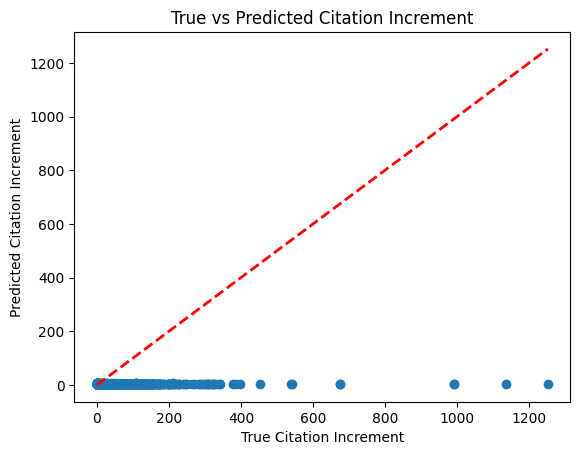

In [120]:
def train_and_evaluate_temporal_gnn(train, valid):
    # 准备图数据
    x, edge_index, edge_attr, node_ids = prepare_temporal_graph_data(train, valid)
    
    # 创建 author_id 到图节点索引的映射
    author_to_index = {author_id: idx for idx, author_id in enumerate(node_ids)}

    # 定义模型超参数
    num_features = x.shape[1]
    hidden_channels = 64
    
    # 初始化模型
    model = TemporalAuthorGNN(num_features, hidden_channels)
    
    # 损失函数和优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mse_criterion = torch.nn.MSELoss()
    
    # 准备验证集目标值
    valid_author_ids = valid['author_id'].unique()
    valid_targets = []
    valid_indices = []
    
    for author_id in valid_author_ids:
        if author_id in author_to_index:
            author_index = author_to_index[author_id]
            valid_target = valid[valid['author_id'] == author_id]['n_citation'].values[0]
            
            valid_targets.append(valid_target)
            valid_indices.append(author_index)
    
    valid_targets = torch.tensor(valid_targets, dtype=torch.float)
    
    # 训练循环
    model.train()
    best_mae = float('inf')
    best_model = None
    
    for epoch in range(80):
        optimizer.zero_grad()
        
        # 前向传播
        predictions = model(x, edge_index, edge_attr)
        
        # 计算损失
        loss = mse_criterion(predictions[valid_indices], valid_targets)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 模型评估
        with torch.no_grad():
            model.eval()
            pred_values = predictions[valid_indices].numpy()
            true_values = valid_targets.numpy()
            
            # 计算评估指标
            mae = mean_absolute_error(true_values, pred_values)
            r2 = r2_score(true_values, pred_values)
            
            # 保存最佳模型
            if mae < best_mae:
                best_mae = mae
                best_model = model.state_dict().copy()
            
            # 每10轮打印一次评估指标
            if epoch % 10 == 0:
                print(f'Epoch {epoch}:')
                print(f'MSE Loss: {loss.item():.4f}')
                print(f'MAE: {mae:.4f}')
                print(f'R2 Score: {r2:.4f}')
                print('-' * 30)
    
    # 恢复最佳模型
    model.load_state_dict(best_model)
    
    # 最终评估
    model.eval()
    with torch.no_grad():
        final_predictions = model(x, edge_index, edge_attr)[valid_indices].numpy()
        final_true_values = valid_targets.numpy()
        
        final_mse = mean_squared_error(final_true_values, final_predictions)
        final_mae = mean_absolute_error(final_true_values, final_predictions)
        final_r2 = r2_score(final_true_values, final_predictions)
        
        print("\n最终模型性能:")
        print(f"MSE: {final_mse:.4f}")
        print(f"MAE: {final_mae:.4f}")
        print(f"R2 Score: {final_r2:.4f}")
    
    # 可视化预测结果
    plt.scatter(final_true_values, final_predictions)
    plt.plot([final_true_values.min(), final_true_values.max()], 
            [final_true_values.min(), final_true_values.max()], 
            'r--', lw=2)
    plt.xlabel("True Citation Increment")
    plt.ylabel("Predicted Citation Increment")
    plt.title("True vs Predicted Citation Increment")
    plt.show()
    
    return model, final_predictions, {
        'mse': final_mse,
        'mae': final_mae,
        'r2': final_r2
    }


# 使用示例
model, predictions, metrics = train_and_evaluate_temporal_gnn(train, valid)


In [87]:
###全优化
import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def calculate_h_index(citations):
    """计算H指数"""
    sorted_citations = sorted(citations, reverse=True)
    h_index = 0
    for i, cite_count in enumerate(sorted_citations, 1):
        if cite_count >= i:
            h_index = i
        else:
            break
    return h_index

def temporal_encoding(year, base=10000.0, dim=10):
    """
    为年份创建正弦/余弦位置编码
    """
    embeddings = np.zeros(dim)
    for i in range(0, dim, 2):
        embeddings[i] = np.sin(year / (base ** ((2 * i) / dim)))
        embeddings[i+1] = np.cos(year / (base ** ((2 * i) / dim)))
    
    return embeddings

def extract_author_features(group):
    """提取作者特征，增加更多维度"""
    return {
        'total_citation': group['n_citation'].sum(),
        'paper_count': len(group),
        'avg_citation': group['n_citation'].mean(),
        'min_year': group['year'].min(),
        'max_year': group['year'].max(),
        'h_index': calculate_h_index(group['n_citation']),
        'citation_variance': group['n_citation'].var(),
        'recent_citation_ratio': group[group['year'] > group['year'].max() - 3]['n_citation'].sum() / max(group['n_citation'].sum(), 1)
    }

class TemporalAuthorGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TemporalAuthorGNN, self).__init__()
        # 增加更多层和复杂结构
        self.conv1 = pyg_nn.TAGConv(num_features, hidden_channels)
        self.conv2 = pyg_nn.TAGConv(hidden_channels, hidden_channels//2)
        self.conv3 = pyg_nn.TAGConv(hidden_channels//2, 1)
        
        # 批归一化和dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels//2)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_attr)
        return x

def prepare_temporal_graph_data(train, valid):
    # 计算作者历史特征
    author_features = train.groupby('author_id').apply(extract_author_features)
    
    # 准备节点特征
    node_features = []
    node_ids = list(author_features.index)
    
    for node in node_ids:
        features = [
            author_features.loc[node]['total_citation'],
            author_features.loc[node]['paper_count'],
            author_features.loc[node]['avg_citation'],
            author_features.loc[node]['max_year'] - author_features.loc[node]['min_year'] + 1,
            author_features.loc[node]['h_index'],
            author_features.loc[node]['citation_variance'],
            author_features.loc[node]['recent_citation_ratio']
        ]
        node_features.append(features)
    
    # 转换节点特征
    x = torch.tensor(node_features, dtype=torch.float)
    
    # 构建边和边属性
    edges = []
    edge_attrs = []
    
    # 遍历每篇论文的合作关系
    for paper_id, group in train.groupby('id'):
        authors = group['author_id'].tolist()
        year = group['year'].iloc[0]
        
        # 创建作者间的边
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                author1 = authors[i]
                author2 = authors[j]
                
                # 边的索引
                edge = [node_ids.index(author1), node_ids.index(author2)]
                edges.append(edge)
                edges.append(edge[::-1])  # 添加反向边
                
                # 边属性使用论文发表年份和时间编码
                edge_attrs.append(temporal_encoding(year))
                edge_attrs.append(temporal_encoding(year))
    
    # 转换边和边属性
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    return x, edge_index, edge_attr, node_ids

def train_and_evaluate_temporal_gnn(train, valid):
    # 准备图数据
    x, edge_index, edge_attr, node_ids = prepare_temporal_graph_data(train, valid)
    
    # 定义模型超参数
    num_features = x.shape[1]
    hidden_channels = 64
    
    # 初始化模型
    model = TemporalAuthorGNN(num_features, hidden_channels)
    
    # 损失函数和优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # 学习率调度器
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-4
    )
    
    mse_criterion = torch.nn.MSELoss()
    
    # 准备验证集目标值
    valid_author_ids = valid['author_id'].unique()
    valid_targets = []
    valid_indices = []
    
    for author_id in valid_author_ids:
        author_index = node_ids.index(author_id)
        valid_target = valid[valid['author_id'] == author_id]['n_citation'].values[0]
        
        valid_targets.append(valid_target)
        valid_indices.append(author_index)
    
    valid_targets = torch.tensor(valid_targets, dtype=torch.float)
    
    # 训练循环
    model.train()
    best_mae = float('inf')
    best_model = None
    
    # 早停
    early_stopping_patience = 20
    no_improvement_epochs = 0
    
    for epoch in range(80):
        optimizer.zero_grad()
        
        # 前向传播
        predictions = model(x, edge_index, edge_attr)
        
        # 计算损失
        loss = mse_criterion(predictions[valid_indices], valid_targets)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 模型评估
        with torch.no_grad():
            model.eval()
            pred_values = predictions[valid_indices].numpy()
            true_values = valid_targets.numpy()
            
            # 计算评估指标
            mae = mean_absolute_error(true_values, pred_values)
            r2 = r2_score(true_values, pred_values)
            
            # 保存最佳模型
            if mae < best_mae:
                best_mae = mae
                best_model = model.state_dict().copy()
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                
                # 早停
                if no_improvement_epochs > early_stopping_patience:
                    print("Early stopping triggered")
                    break
            
            # 更新学习率
            lr_scheduler.step(mae)
            
            # 每10轮打印一次评估指标
            if epoch % 10 == 0:
                print(f'Epoch {epoch}:')
                print(f'MSE Loss: {loss.item():.4f}')
                print(f'MAE: {mae:.4f}')
                print(f'R2 Score: {r2:.4f}')
                print('-' * 30)
    
    # 恢复最佳模型
    model.load_state_dict(best_model)
    
    # 最终评估
    model.eval()
    with torch.no_grad():
        final_predictions = model(x, edge_index, edge_attr)[valid_indices].numpy()
        final_true_values = valid_targets.numpy()
        
        final_mse = mean_squared_error(final_true_values, final_predictions)
        final_mae = mean_absolute_error(final_true_values, final_predictions)
        final_r2 = r2_score(final_true_values, final_predictions)
        
        print("\n最终模型性能:")
        print(f"MSE: {final_mse:.4f}")
        print(f"MAE: {final_mae:.4f}")
        print(f"R2 Score: {final_r2:.4f}")
    
    # 可视化预测结果
    plt.figure(figsize=(10, 6))
    plt.scatter(final_true_values, final_predictions)
    plt.plot([final_true_values.min(), final_true_values.max()],
             [final_true_values.min(), final_true_values.max()],
             'r--', lw=2)
    plt.xlabel("True Citations")
    plt.ylabel("Predicted Citations")
    plt.title("True vs Predicted Citations")
    plt.show()
    
    return model, final_predictions, {
        'mse': final_mse,
        'mae': final_mae,
        'r2': final_r2
    }

def cross_validation(train_data, n_splits=5):
    """
    执行交叉验证
    """
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    all_metrics = []
    for fold, (train_index, val_index) in enumerate(kf.split(train_data), 1):
        print(f"Fold {fold}")
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]
        
        model, predictions, metrics = train_and_evaluate_temporal_gnn(train_fold, val_fold)
        all_metrics.append(metrics)

    # 平均指标
    avg_metrics = {
        'mse': np.mean([m['mse'] for m in all_metrics]),
        'mae': np.mean([m['mae'] for m in all_metrics]),
        'r2': np.mean([m['r2'] for m in all_metrics])
    }
    
    print("\n交叉验证平均结果:")
    print(f"平均MSE: {avg_metrics['mse']:.4f}")
    print(f"平均MAE: {avg_metrics['mae']:.4f}")
    print(f"平均R2 Score: {avg_metrics['r2']:.4f}")
    
    return avg_metrics

# 使用示例
# cross_validation(train_data)
# 或
model, predictions, metrics = train_and_evaluate_temporal_gnn(train, valid)

/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/604933992.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  author_features = train.groupby('author_id').apply(extract_author_features)
/var/folders/p5/grng0bpx24988f1v2318bx6w0000gn/T/ipykernel_33374/604933992.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  edge_attr = torch.tensor(edge_attrs, dtype=torch.float)


RuntimeError: The size of tensor a (10186040) must match the size of tensor b (1018604) at non-singleton dimension 0

### GNN

#### Test on validation